:::{canonical-tutorial} tutorials/basics/clustering-2017
:::

# Preprocessing and clustering 3k PBMCs (legacy workflow)

In [ ]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) {cite:p}`Satija2015`.

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
!mkdir -p data
!test -f data/pbmc3k_filtered_gene_bc_matrices.tar.gz || curl https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir -p write

:::{note}
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.
:::

:::{note}
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.
:::

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=80, facecolor="white")

In [5]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

Read in the count matrix into an {class}`~anndata.AnnData` object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [6]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

:::{note}
See {doc}`anndata:tutorials/notebooks/getting-started` for a more comprehensive introduction to `AnnData`.
:::

In [8]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [9]:
# adata.X = adata.X.astype("int32") # needed to match R results
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

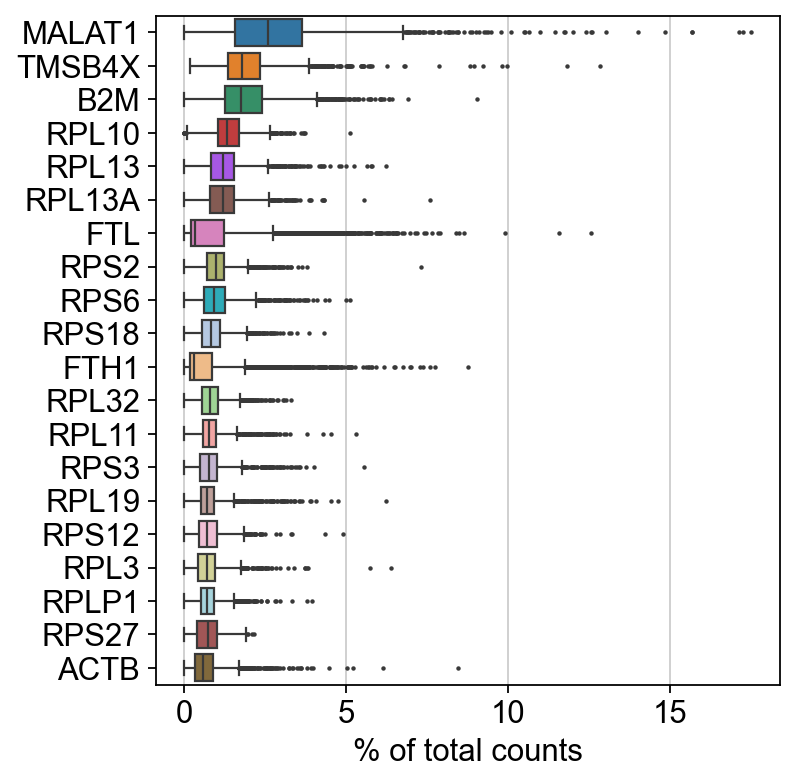

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [11]:
sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows {cite:p}`Lun2016`:

> High proportions are indicative of poor-quality cells {cite:p}`Islam2013,Ilicic2016`, possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [12]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

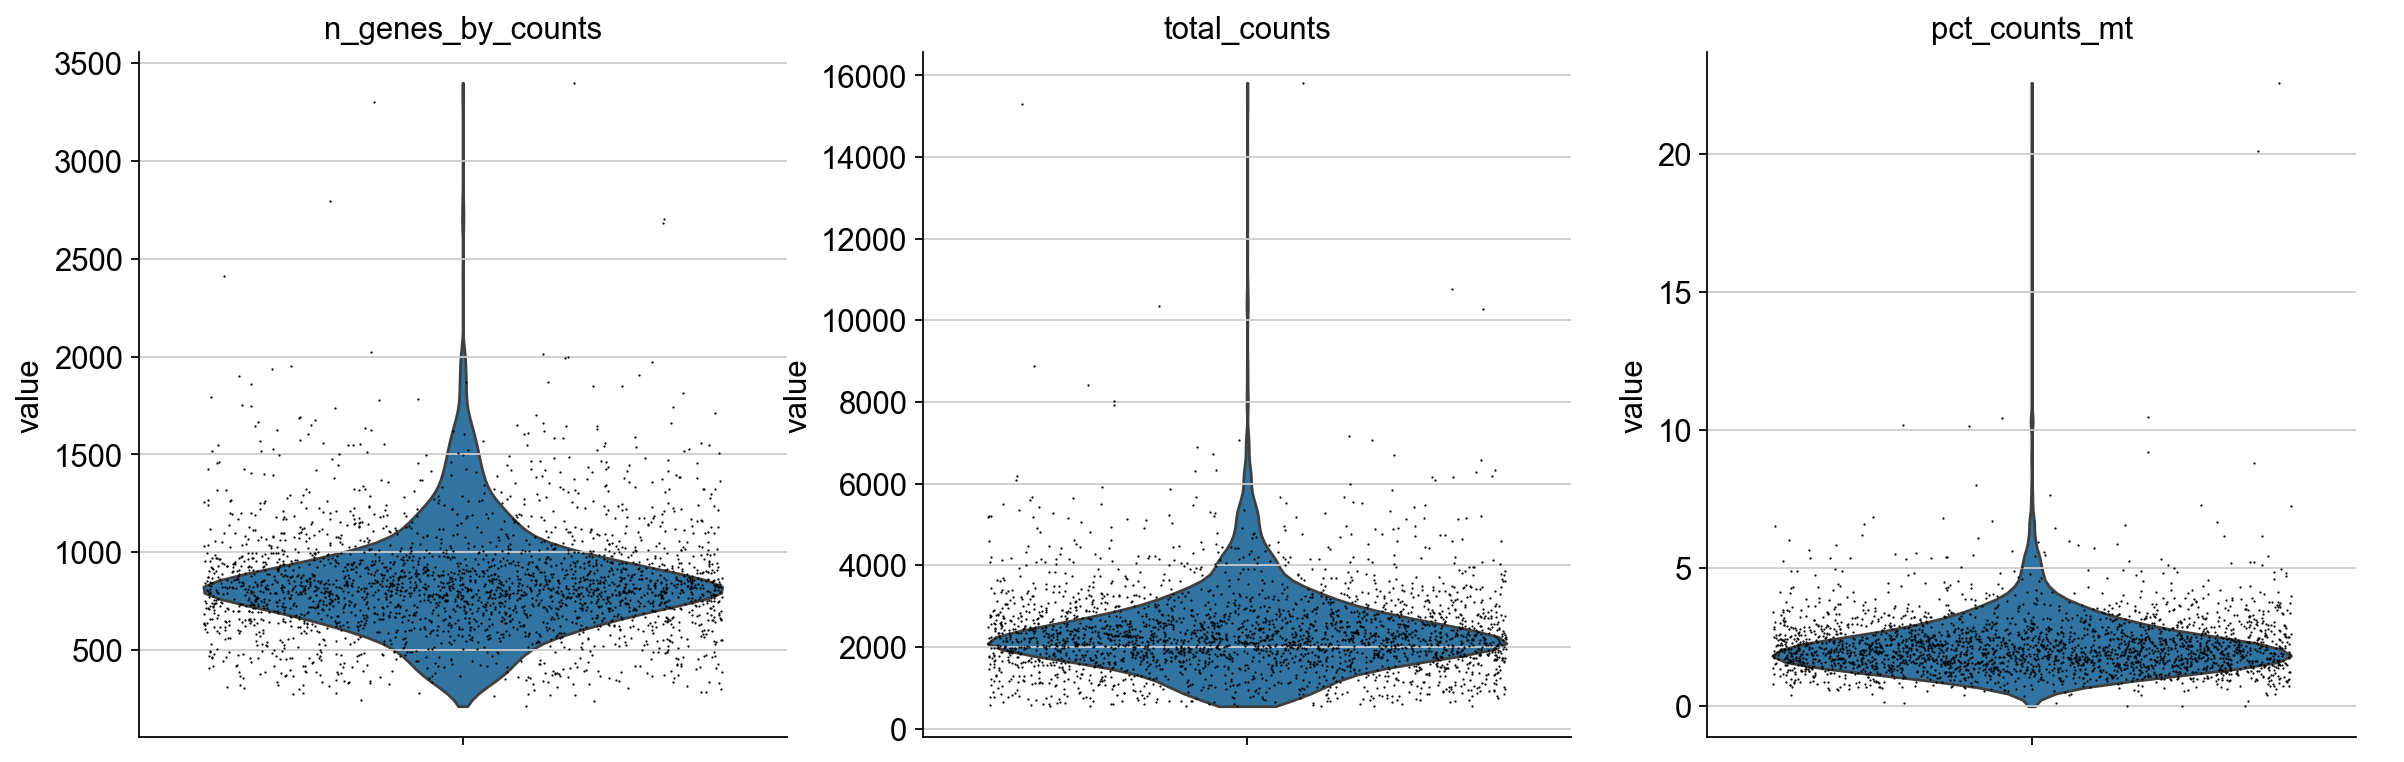

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

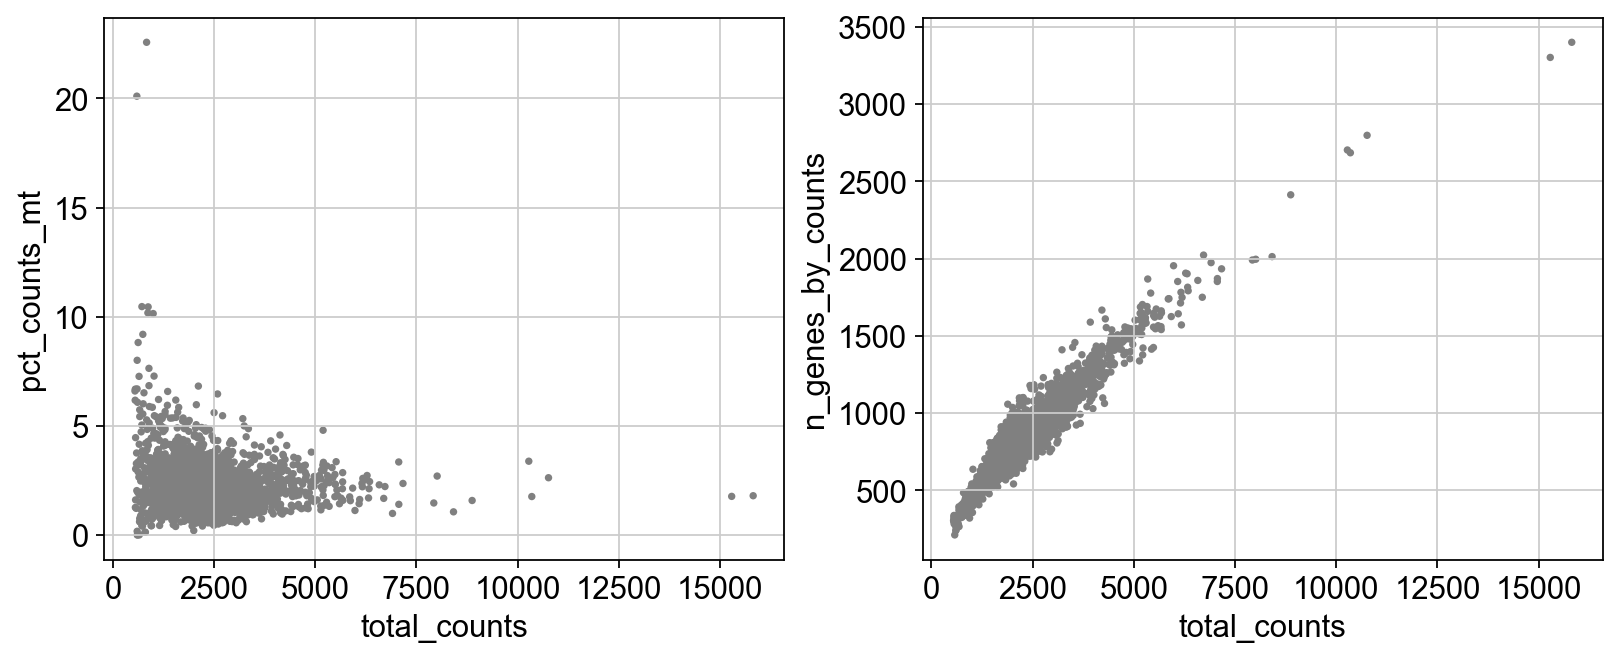

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

Actually do the filtering by slicing the `AnnData` object.

In [24]:
adata = adata[
    (adata.obs.n_genes_by_counts < 2500)
    & (adata.obs.n_genes_by_counts > 200)
    & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)

Logarithmize the data:

In [27]:
sc.pp.log1p(adata)

Identify highly-variable genes. Up to ties, this should match exactly the tutorial from Seurat: https://satijalab.org/seurat/articles/pbmc3k_tutorial

In [28]:
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

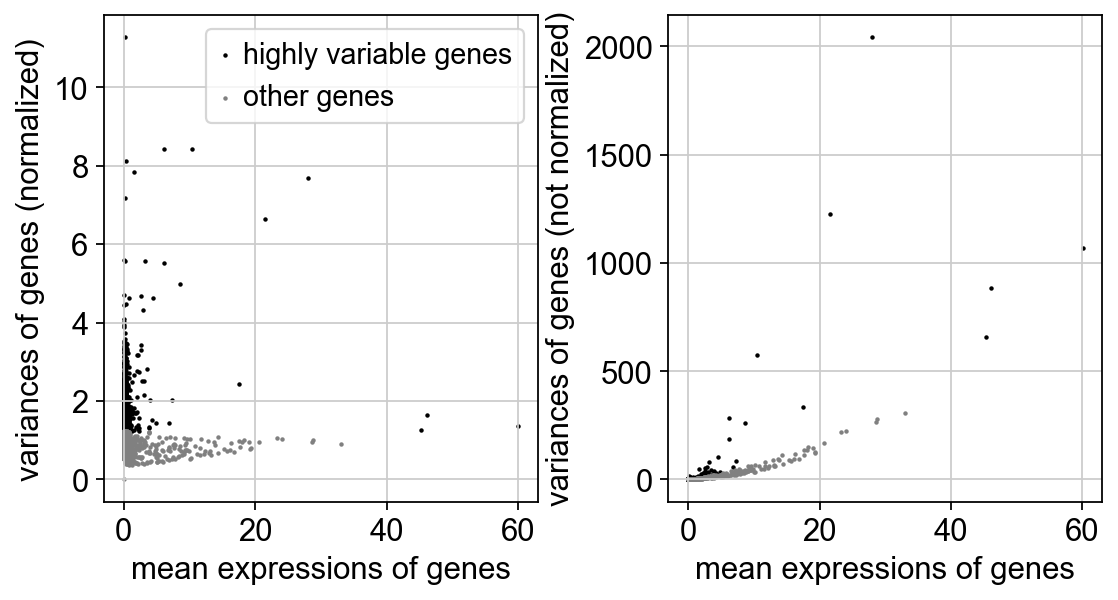

In [29]:
sc.pl.highly_variable_genes(adata)

:::{note}
The result of the previous highly-variable-genes detection is stored as an annotation in `.var["highly_variable"]` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.
:::

Scale each gene to unit variance. Clip values exceeding standard deviation 10. To match [Seurat's pbmc 3k tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial), you can elect to regress out only `pct_counts_mt` and subset (which appears to be optional in their tutorial).

In [ ]:
import numpy as np

adata.layers["scaled_hvg"] = adata.X.toarray()
adata.layers["scaled_hvg"][:, ~adata.var["highly_variable"].to_numpy()] = np.nan
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled_hvg")
sc.pp.scale(adata, max_value=10, layer="scaled_hvg")

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.pp.pca(adata, layer="scaled_hvg", svd_solver="arpack")

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

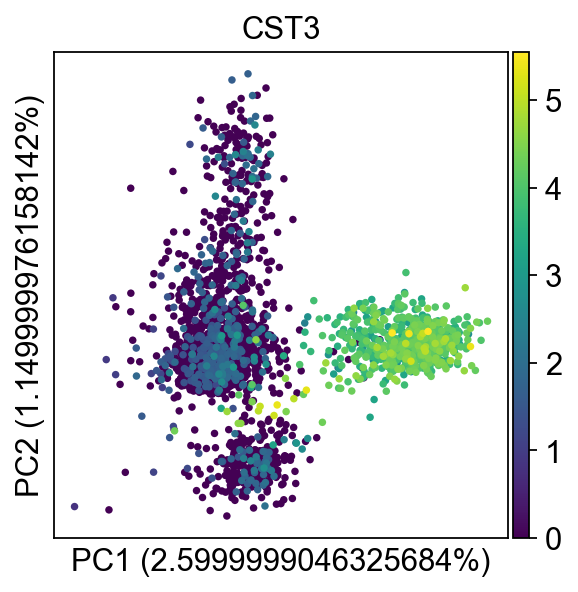

In [35]:
sc.pl.pca(adata, annotate_var_explained=True, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

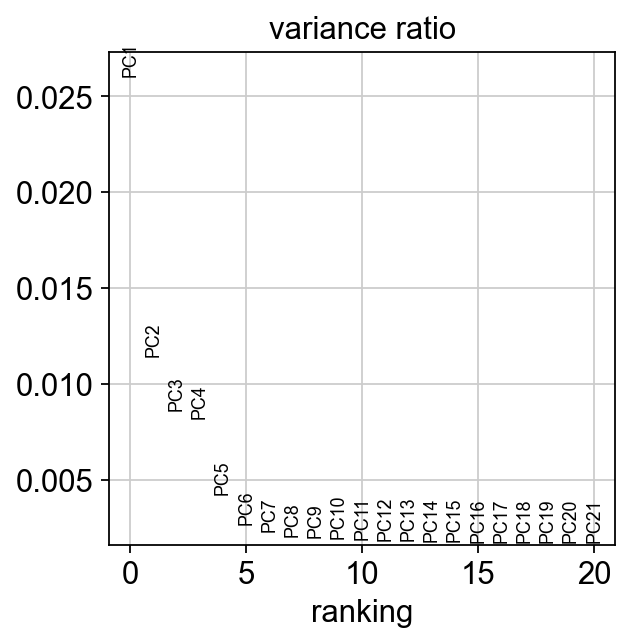

In [36]:
sc.pl.pca_variance_ratio(adata, n_pcs=20)

While our alogrithms differ, yielding slightly different components, the rankings match those found in [the Seurat tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial) modulo the sign.

/Users/philipp.angerer/Library/Application Support/hatch/env/virtual/scanpy/v-02wEvu/hatch-test.stable/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


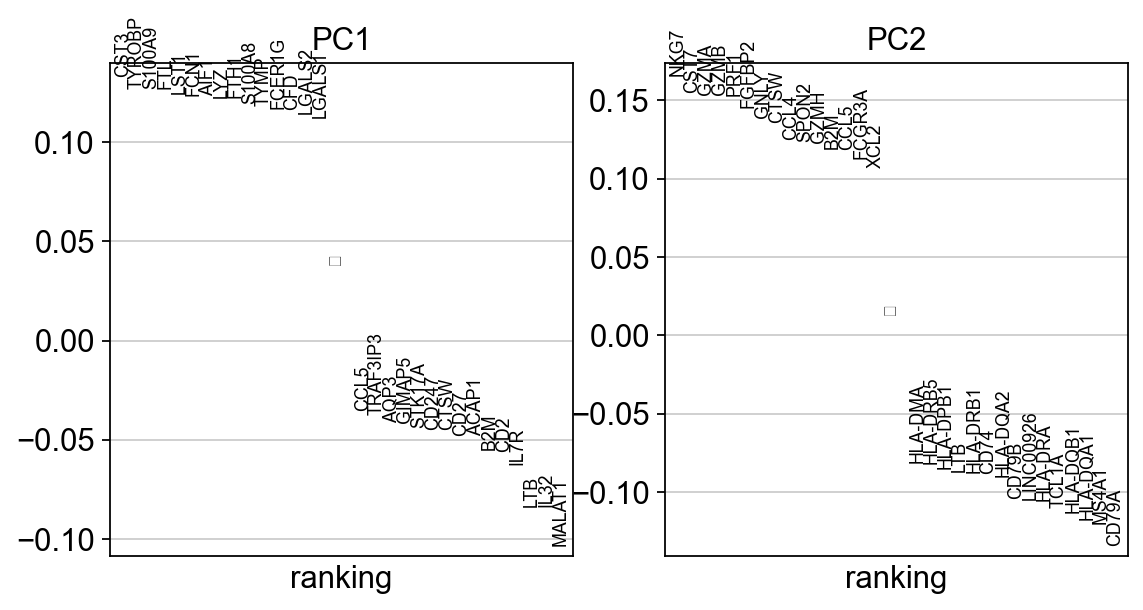

In [37]:
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/Users/philipp.angerer/Library/Application Support/hatch/env/virtual/scanpy/v-02wEvu/hatch-test.stable/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP {cite:p}`McInnes2018`, see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [39]:
sc.tl.umap(adata)

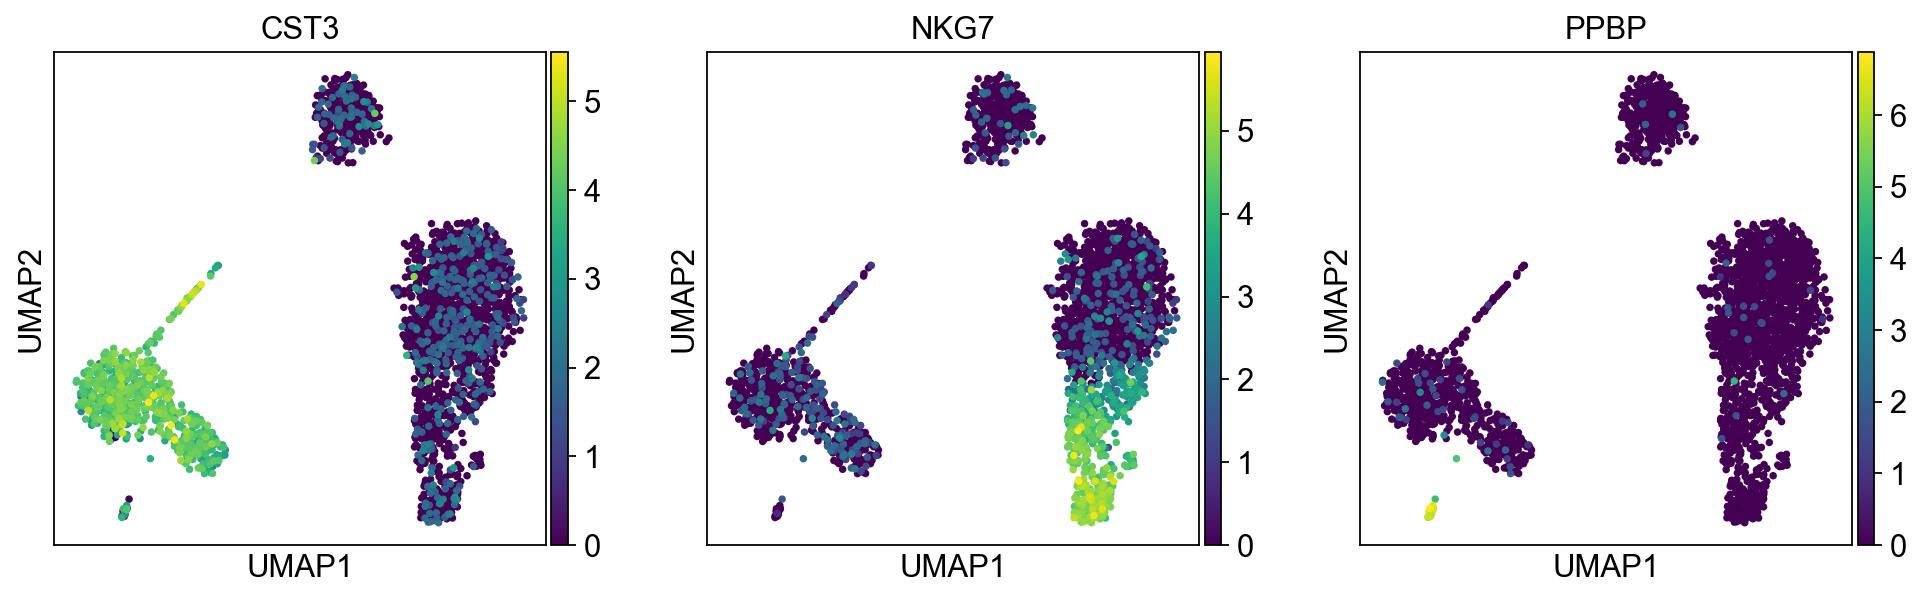

In [40]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

As we set the `.X` attribute of `adata` to be the normalized data, the previous plots showed the normalized gene expression.
You can also plot the counts directly, or the "scaled_hvg" (normalized, logarithmized, and scaled) data.

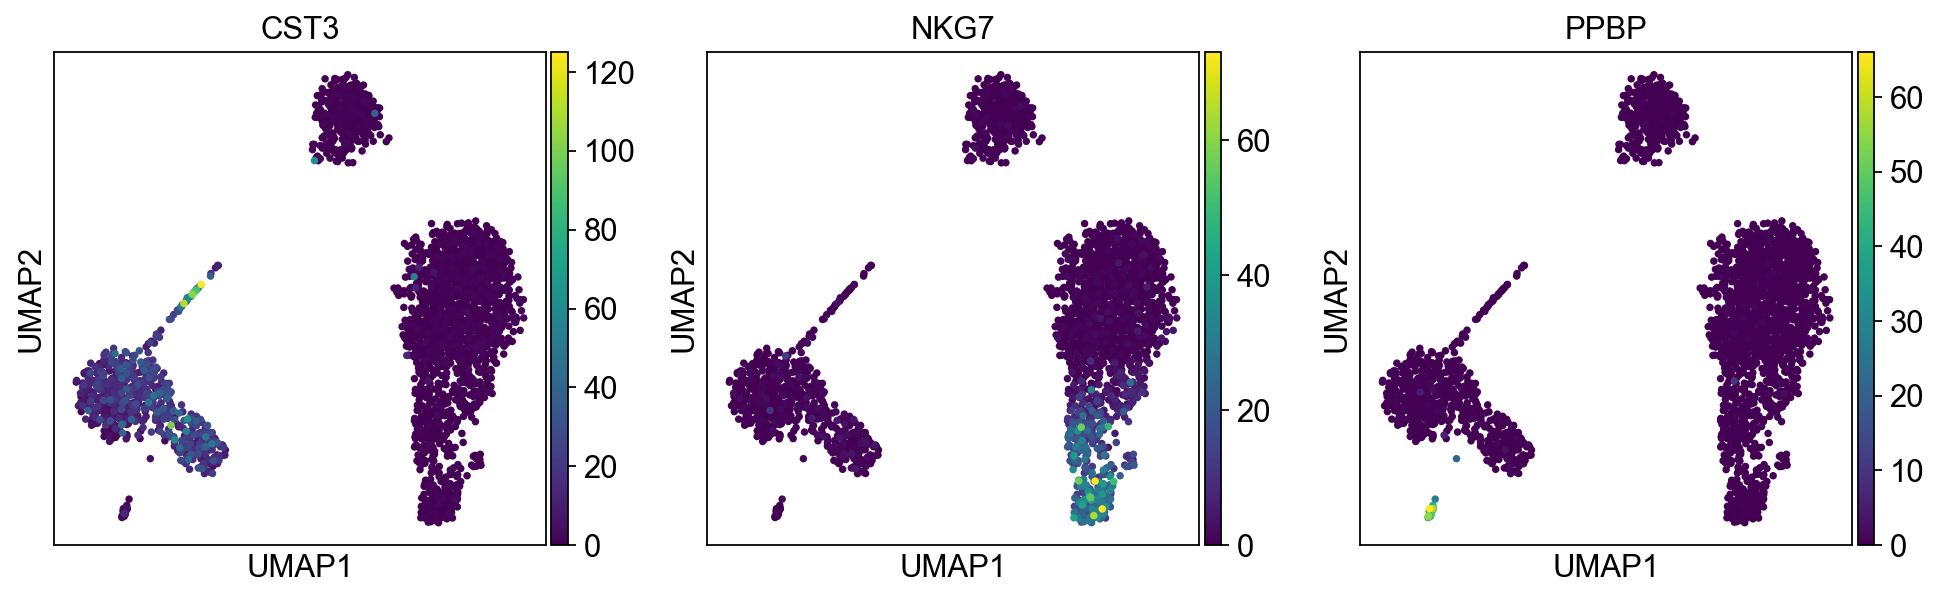

In [41]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="counts")

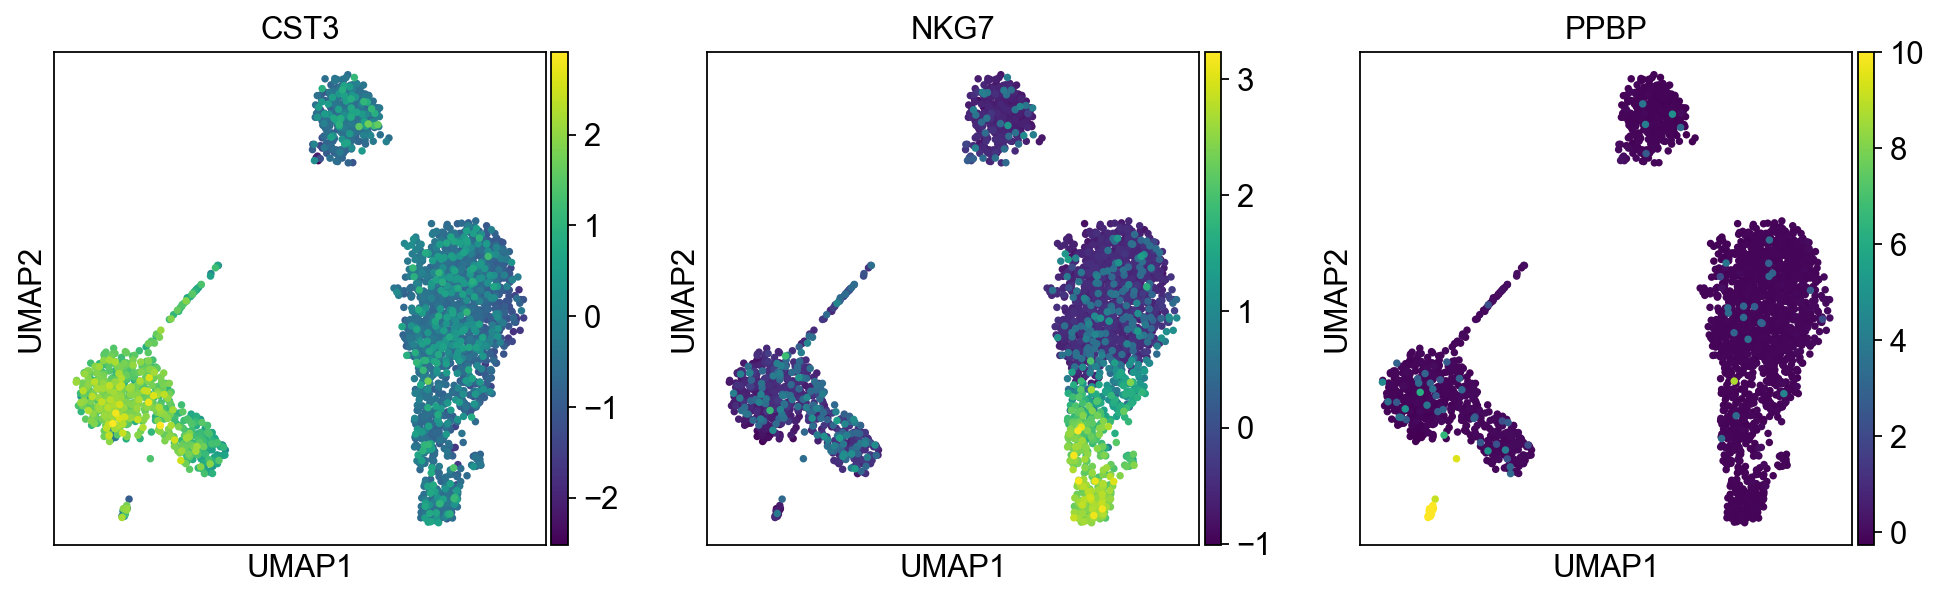

In [ ]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="scaled_hvg")

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by {cite:t}`Traag2019`.
Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [46]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
adata.obs["leiden"] = adata.obs["leiden"].copy()
adata.uns["leiden"] = adata.uns["leiden"].copy()
adata.obsm["X_umap"] = adata.obsm["X_umap"].copy()

Plot the clusters, which agree quite well with the result of Seurat.

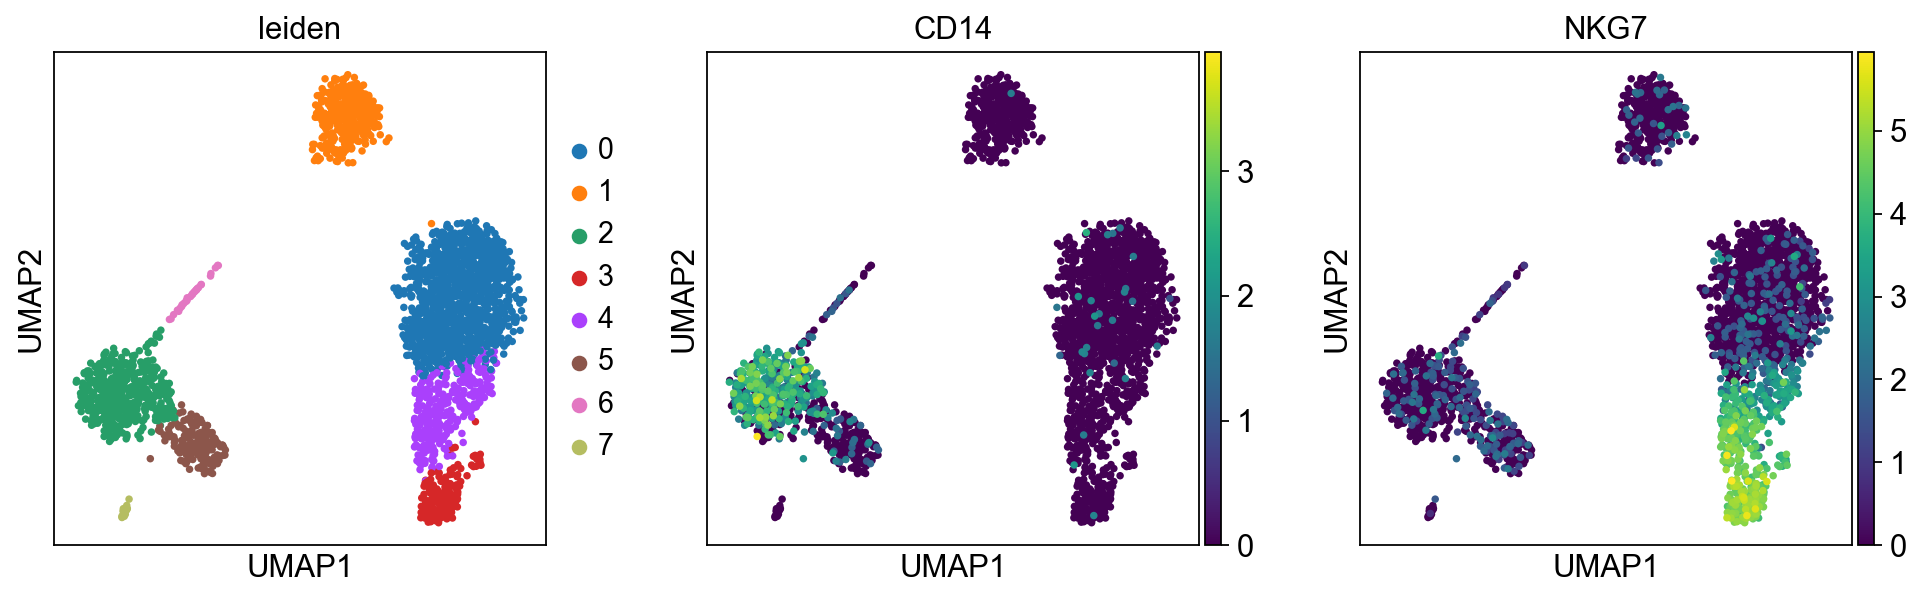

In [47]:
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])

## Finding marker genes

Let's bring back the normalized counts, which will serve as the basis for all following steps.

In [ ]:
adata.X = adata.layers["normalized"].copy()

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

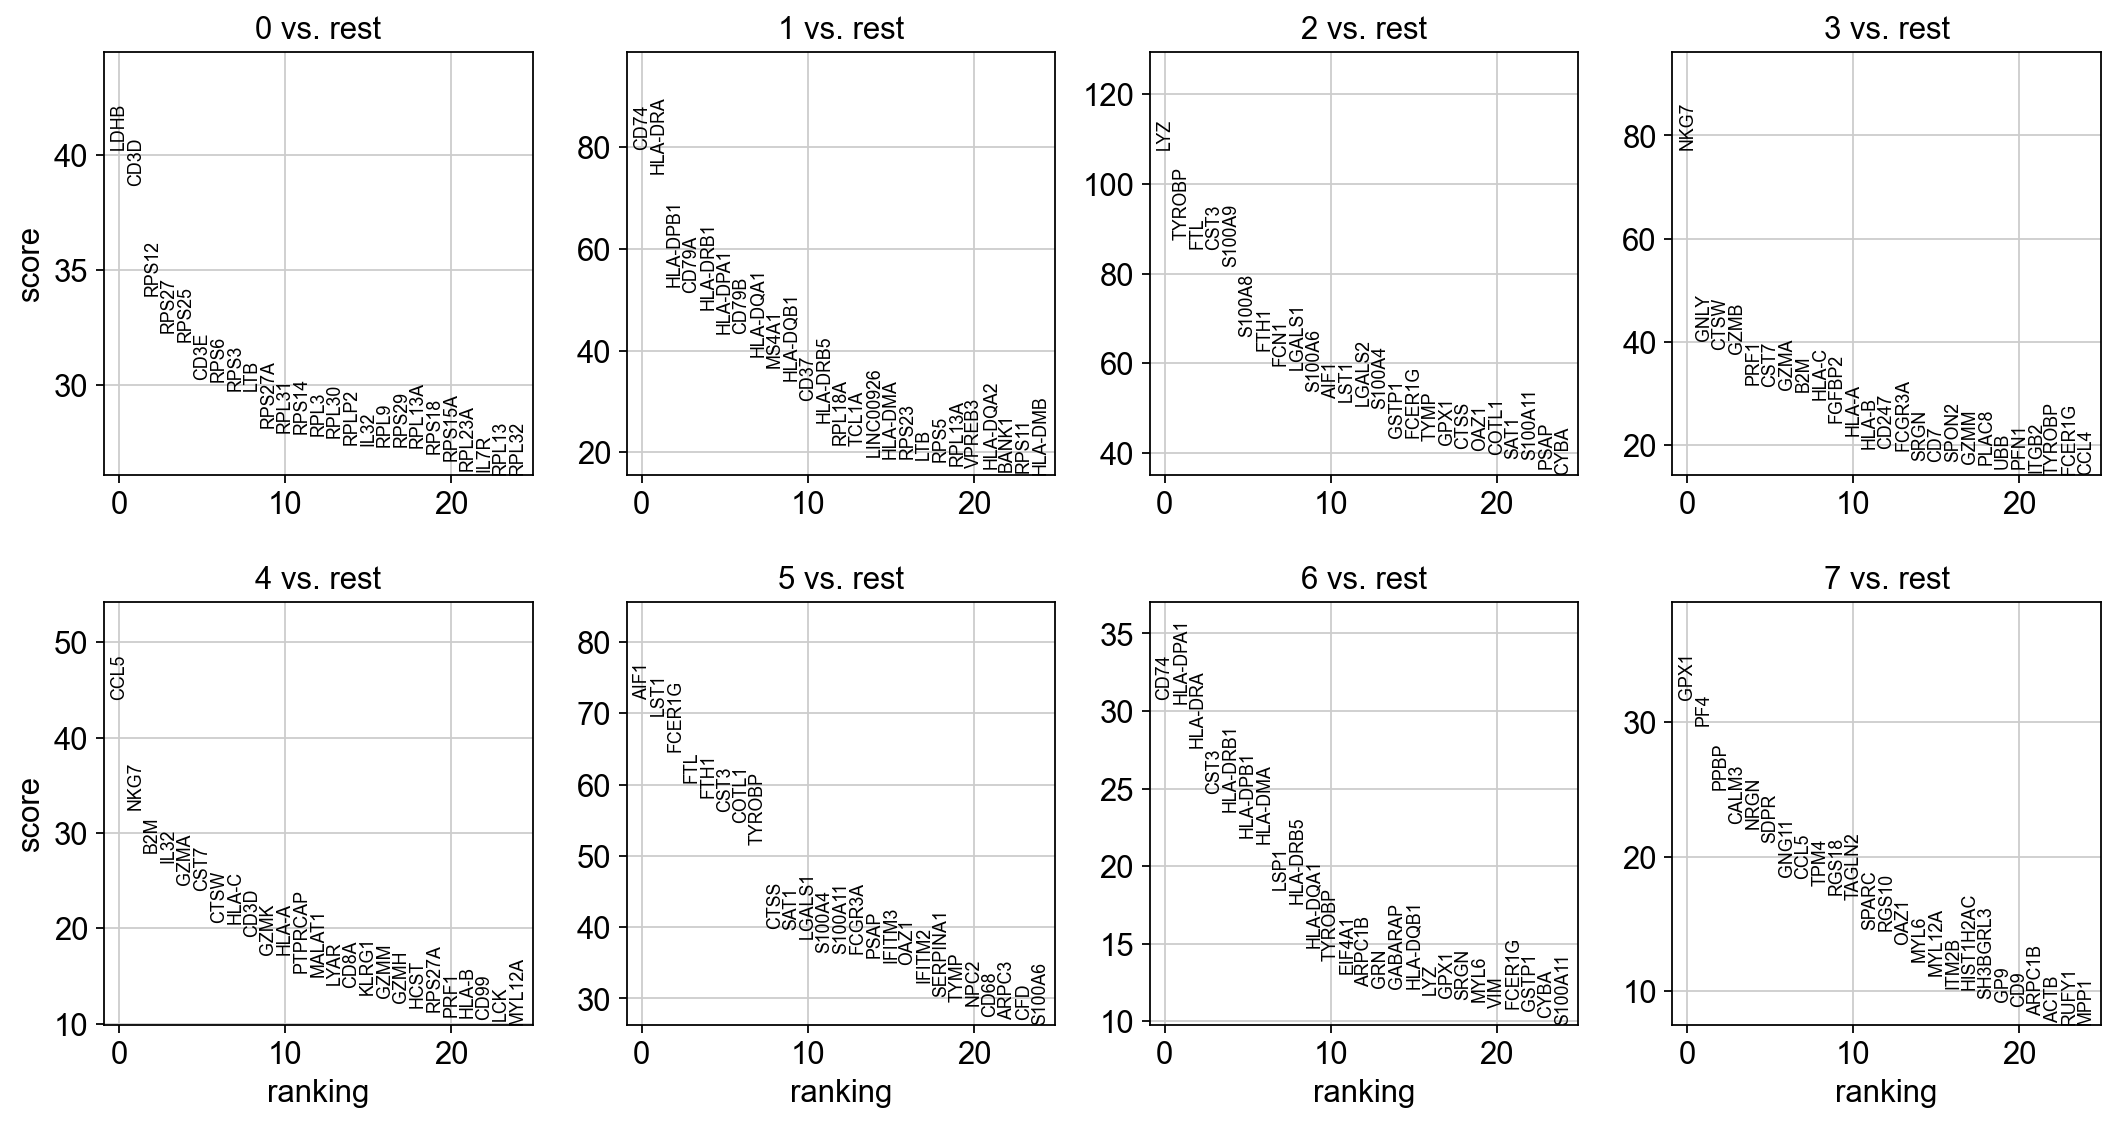

In [48]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [49]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar.
We recommend using the latter in publications, see e.g., {cite:t}`Soneson2018`.
You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

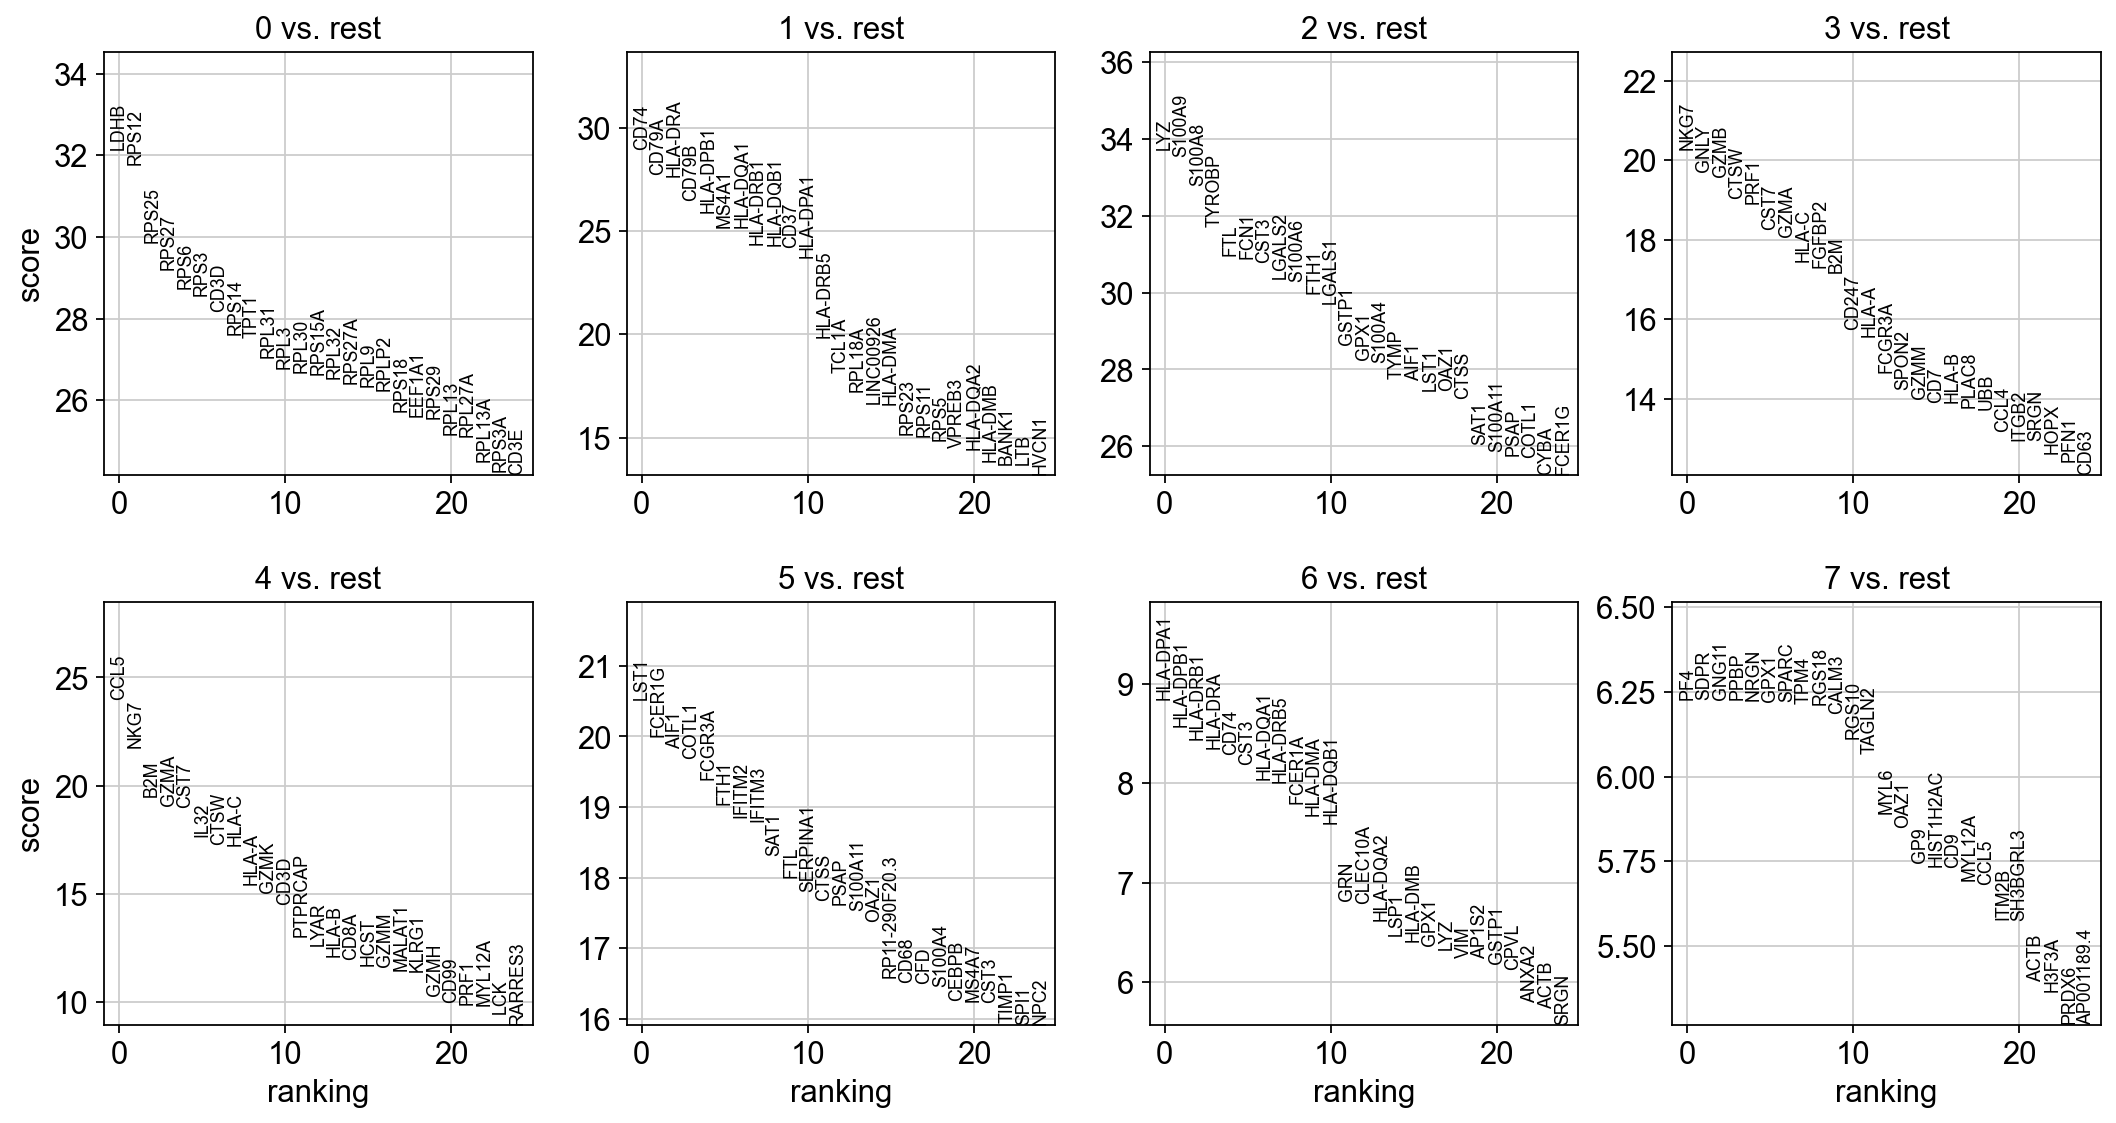

In [50]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [51]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by {cite:t}`Ntranos2019`.
The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate.
{cite:t}`Clark2014` has more details.

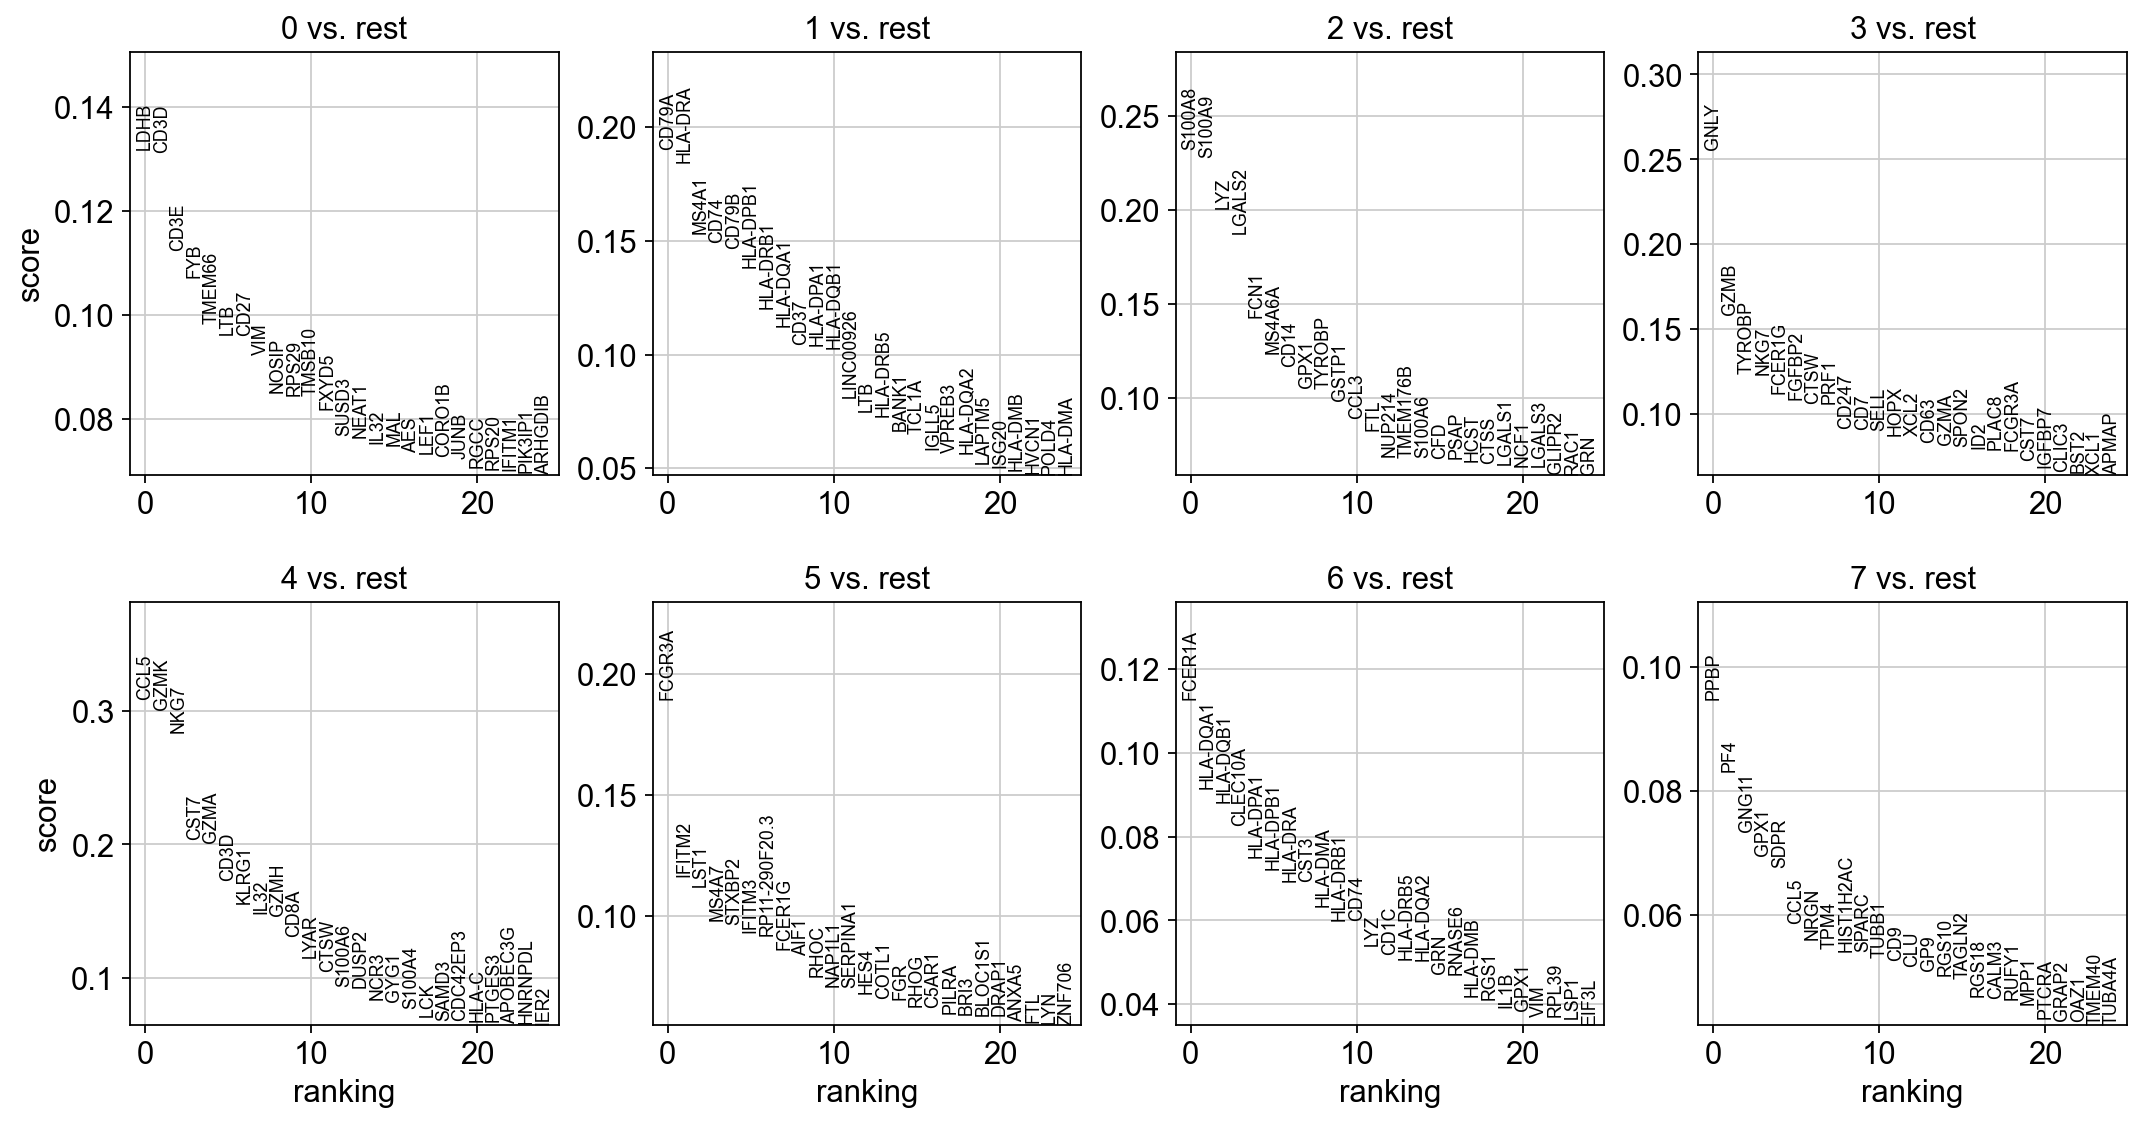

In [53]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Most of these genes are found in the highly expressed genes with notable exceptions like `CD8A` (see the below dotplot).

Leiden Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [54]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [57]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [59]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,CD74,LYZ,NKG7,CCL5,LST1,HLA-DPA1,PF4
1,RPS12,CD79A,S100A9,GNLY,NKG7,FCER1G,HLA-DPB1,SDPR
2,RPS25,HLA-DRA,S100A8,GZMB,B2M,AIF1,HLA-DRB1,GNG11
3,RPS27,CD79B,TYROBP,CTSW,GZMA,COTL1,HLA-DRA,PPBP
4,RPS6,HLA-DPB1,FTL,PRF1,CST7,FCGR3A,CD74,NRGN


Get a table with the scores and groups.

In [60]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LDHB,1.075597e-226,CD74,1.972305e-184,LYZ,2.283102e-249,NKG7,2.147819e-91,CCL5,3.016916e-127,LST1,1.219211e-93,HLA-DPA1,9.083160e-19,PF4,4.722886e-10
1,RPS12,1.419355e-221,CD79A,1.882747e-169,S100A9,9.953529e-247,GNLY,1.451471e-86,NKG7,4.605373e-105,FCER1G,4.872332e-89,HLA-DPB1,1.012875e-17,SDPR,4.733899e-10
2,RPS25,7.659736e-196,HLA-DRA,2.840744e-168,S100A8,7.353438e-236,GZMB,2.175571e-85,B2M,6.765274e-85,AIF1,1.527480e-87,HLA-DRB1,3.140833e-17,GNG11,4.733899e-10
3,RPS27,1.778216e-187,CD79B,1.868216e-154,TYROBP,6.599034e-221,CTSW,7.910419e-81,GZMA,4.620187e-81,COTL1,2.926464e-86,HLA-DRA,6.528837e-17,PPBP,4.744938e-10
4,RPS6,1.743317e-181,HLA-DPB1,3.333386e-148,FTL,1.173436e-210,PRF1,8.084725e-80,CST7,2.693918e-80,FCGR3A,8.680798e-84,CD74,1.090345e-16,NRGN,4.800511e-10


Compare to a single cluster: 

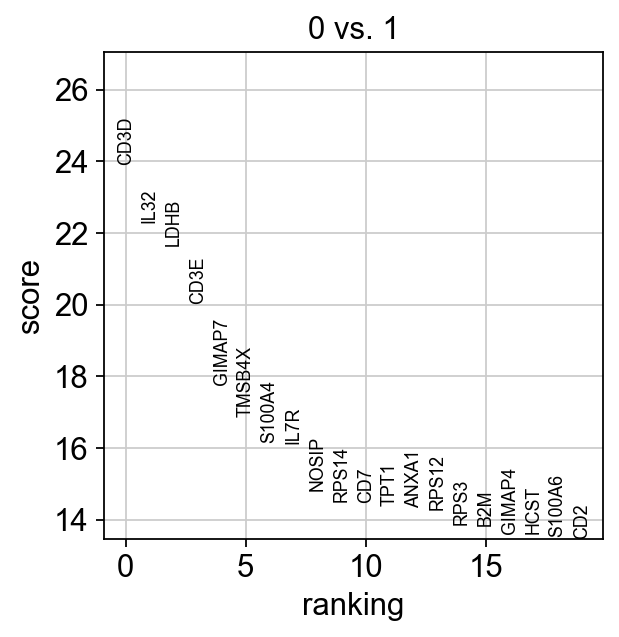

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/Users/philipp.angerer/Dev/Python/scanpy/src/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


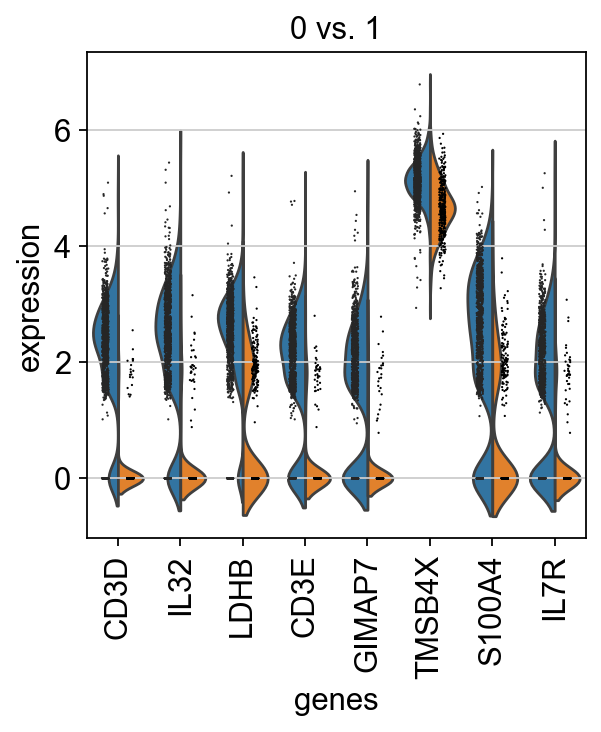

In [62]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [63]:
adata = sc.read(results_file)

/Users/philipp.angerer/Dev/Python/scanpy/src/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


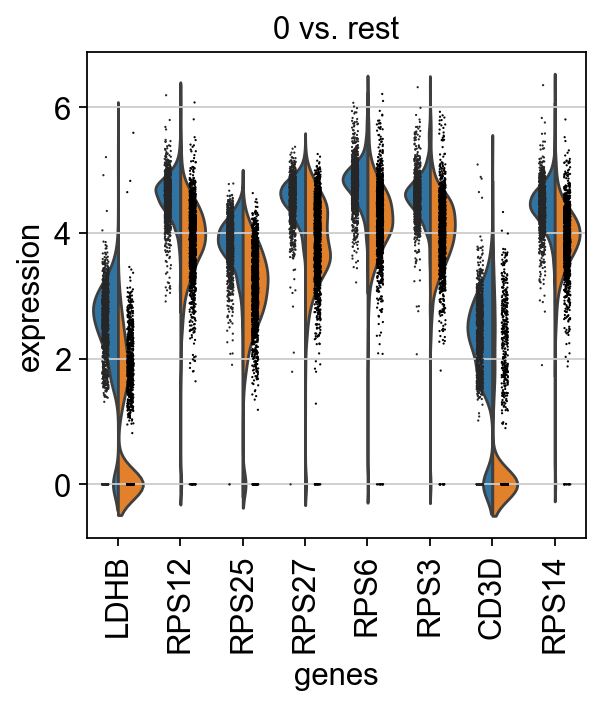

In [64]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

If you want to compare a certain gene across groups, use the following.

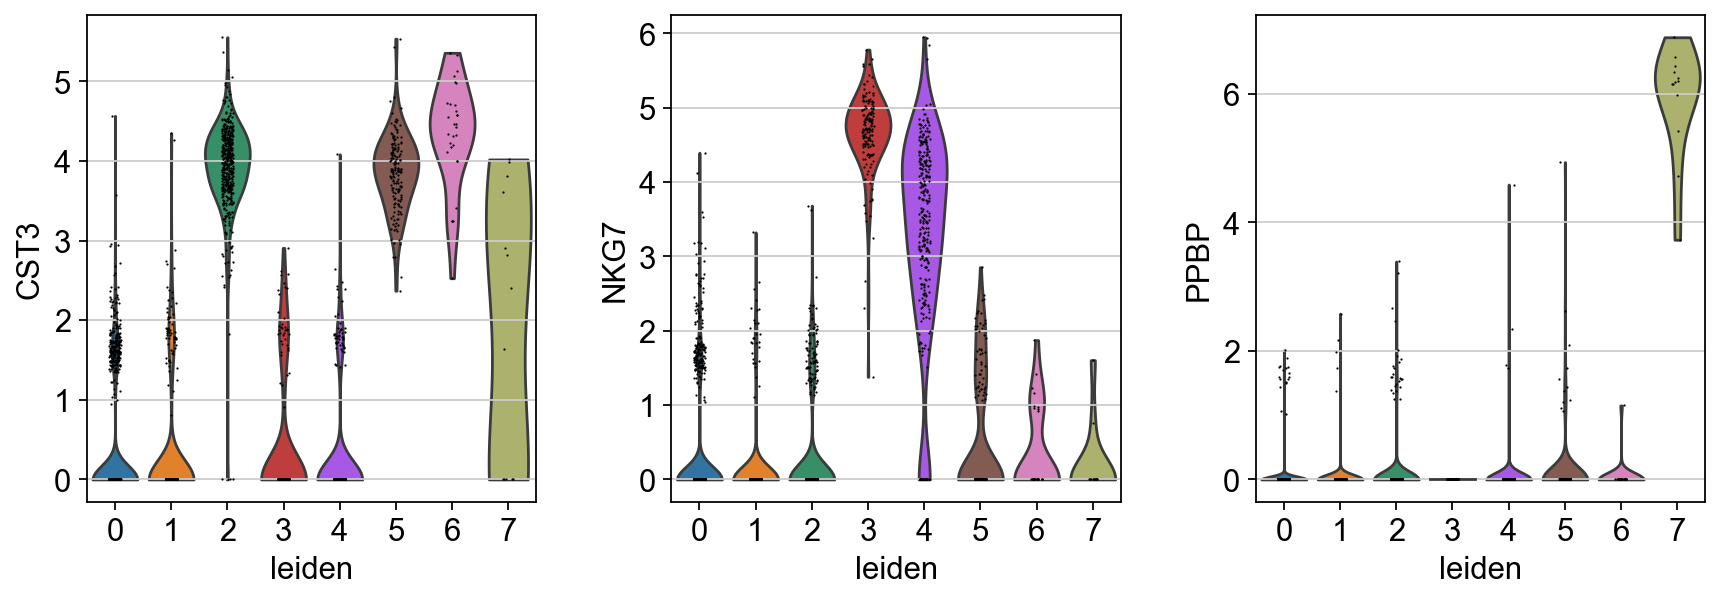

In [65]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

Actually mark the cell types.

In [66]:
new_cluster_names = [
    "CD4 T",
    "B",
    "CD14+ Monocytes",
    "NK",
    "CD8 T",
    "FCGR3A+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

saving figure to file figures/umap.pdf


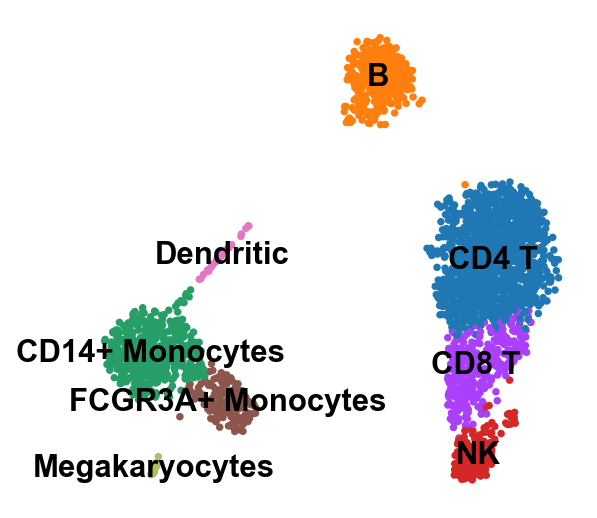

In [67]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

Now that we annotated the cell types, let us visualize the marker genes.

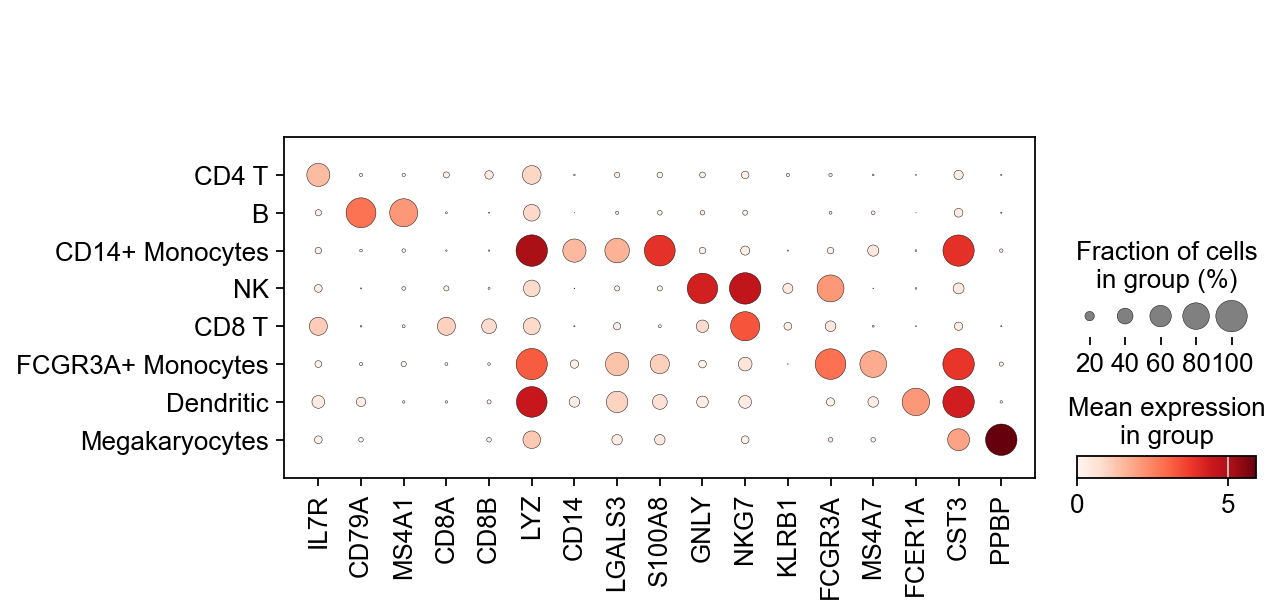

In [68]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

There is also a very compact violin plot.

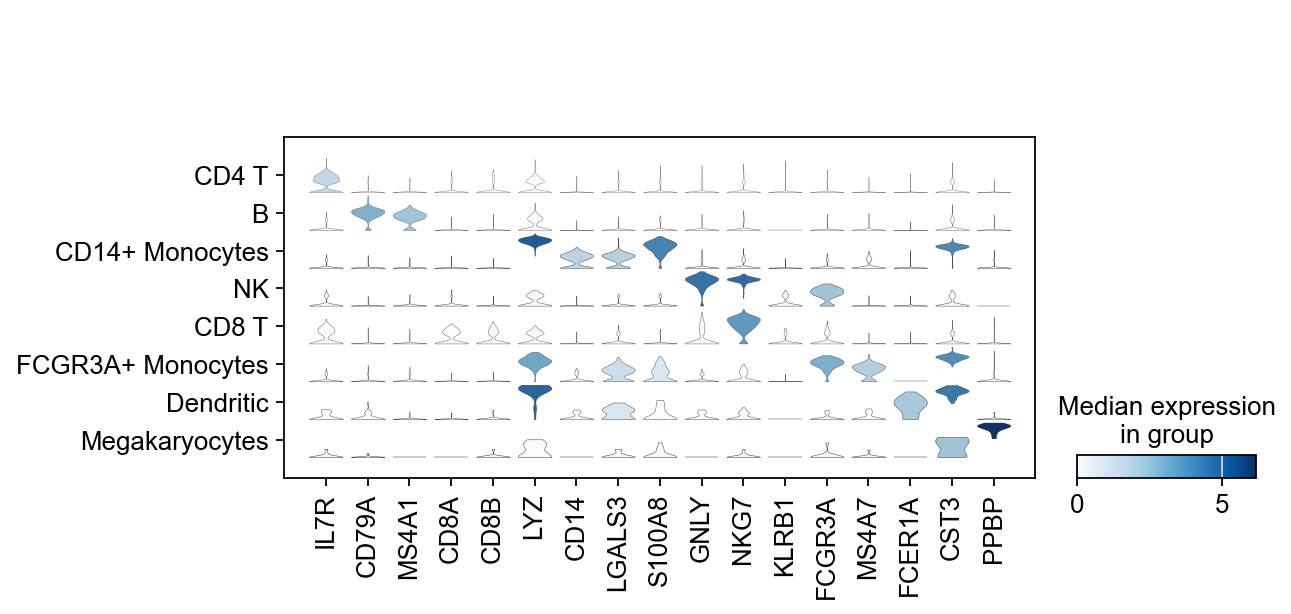

In [69]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden")

During the course of this analysis, the AnnData accumlated the following annotations.

In [70]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

In [71]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [72]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")

AttributeError: 'NoneType' object has no attribute 'to_adata'